### Classify



#### Import modules

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob, shutil, itertools, random
from nilearn import plotting, input_data, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")
from nilearn.masking import compute_brain_mask, apply_mask
from nilearn import image

#!pip install surfplot
#!pip install neuromaps
#!pip install matplotlib --upgrade

n_regions       = 293


#### Reading in Twin-list and computing ISC among twins

In [4]:
twin_df = pd.read_csv('../data/00_dataset_info/twin_df.csv')

twin_list = twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(twin_list[:3])

twin_df.head()

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]


,Unnamed: 0,family_id,twin_A_id,twin_A_age,twin_A_sex,twin_B_id,twin_B_age,twin_B_sex
0,0,fam-0001,sub-0001,14.0,M,sub-0018,14.0,M
1,1,fam-0116,sub-0003,14.0,M,sub-0233,14.0,F
2,2,fam-0002,sub-0004,11.0,M,sub-0420,11.0,M
3,3,fam-0088,sub-0005,12.0,F,sub-0178,12.0,F
4,4,fam-0178,sub-0006,15.0,M,sub-0329,15.0,F


In [12]:
class_twin_notwin   = np.zeros((n_regions+1, n_twins, 2)) 
class_twin_notwin.shape

(294, 100, 2)

In [13]:
# Computing ISC (functional) for the real twins
n_twins         = len(twin_list)
class_twin_notwin   = np.zeros((n_regions+1, n_twins, 2)) #the additional line is for the anatomical similarity

region_count = []

for curr_region in tqdm(range(n_regions)):
    counter_twin_gt_notwin = 0
    counter_twin_lt_notwin = 0
    
    for  curr_twin in range(len(twin_list)):
        
        twin_pair  = twin_list[curr_twin]
        filename_1 = '../data/03_extract_ts/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        
        filename_2 = '../data/03_extract_ts/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        
        
        #from the remaining people, randomly chose one, excluding the actual twin
        other_twin_list = twin_df['twin_B_id'].values.tolist()
        other_people = [x for x in other_twin_list if x != twin_pair[1]]  
        no_twin_filename_1 = '../data/03_extract_ts/' + random.choice(other_people) + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        no_twin_data1 = np.load(no_twin_filename_1) 

         
        res_twins = np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1]
        #print(res_twins)
        
        res_notwins = np.corrcoef(twin1_data[:,curr_region], no_twin_data1[:,curr_region])[0,1]
        #print(res_notwins)
        
        if (res_twins > res_notwins):
            #print('### twin >> notwins')
            counter_twin_gt_notwin = counter_twin_gt_notwin + 1
        else:
            #print('--- twin << notwins')
            counter_twin_lt_notwin = counter_twin_lt_notwin +1
            
        class_twin_notwin[curr_region, curr_twin, 0] = res_twins
        class_twin_notwin[curr_region, curr_twin, 1] = res_notwins
        
        #print('----')
        
    region_count.append(counter_twin_gt_notwin - counter_twin_lt_notwin)


100%|██████████| 293/293 [00:46<00:00,  6.33it/s]


In [36]:
X = np.vstack( (class_twin_notwin[:,:,0].T , class_twin_notwin[:,:,1].T) )
y = np.hstack((np.ones(n_twins), np.zeros(n_twins)))

print(X.shape)
print(y.shape)

(200, 294)
(200,)


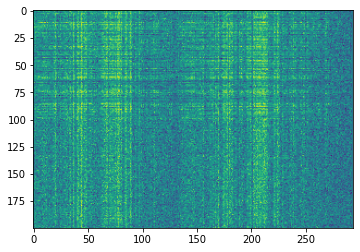

In [37]:
plt.imshow(X)



In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a logistic regression model
model = LogisticRegression()

# fit the model on the training data
model.fit(X_train, y_train)

# predict target variable for test data
y_pred = model.predict(X_test)

# calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)

Accuracy:  0.675


In [42]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score



# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a dummy classifier for baseline performance
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)
dummy_accuracy = dummy.score(X_test, y_test)
print("Dummy accuracy: ", dummy_accuracy)

scores = cross_val_score(dummy, X_train, y_train, cv=cv)

print("Cross-validation scores Dummy: ", scores)
print("Average score Dummy: ", scores.mean())




# create a logistic regression model
model = LogisticRegression()

# use stratified k-fold cross-validation to evaluate model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv)

print("Cross-validation scores: ", scores)
print("Average score: ", scores.mean())

# fit the model on the full training data
model.fit(X_train, y_train)

# predict target variable for test data
y_pred = model.predict(X_test)

# calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)

Dummy accuracy:  0.575
Cross-validation scores Dummy:  [0.375   0.4375  0.4375  0.59375 0.75   ]
Average score Dummy:  0.51875
Cross-validation scores:  [0.875   0.625   0.6875  0.6875  0.71875]
Average score:  0.71875
Accuracy:  0.675
